## Import & Basic Settings

In [32]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from dotenv import load_dotenv

from konlpy.tag import Okt
import numpy as np
from sklearn.preprocessing import normalize

from langchain_openai.embeddings import OpenAIEmbeddings
from sklearn.metrics.pairwise import cosine_similarity

from typing_extensions import TypedDict
from typing import Annotated
from langchain_core.messages import (
    HumanMessage,
    SystemMessage
)
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic
from pydantic import BaseModel
from langgraph.graph import StateGraph, START, END

from keybert import KeyBERT
from transformers import BertModel

from difflib import SequenceMatcher

In [33]:
load_dotenv(os.path.join("config", ".env"))

True

## Construct Eval Dataset

In [4]:
data_dir = os.path.join("data", "01-1.정식개방데이터", "Training", "02.라벨링데이터")
eval_dataset = []

dir_list = os.listdir(data_dir)
for dir_name in dir_list:
    if dir_name == ".DS_Store" or dir_name.endswith(".zip"): continue
    file_list = os.listdir(os.path.join(data_dir, dir_name))
    for file_name in tqdm(file_list, desc=f"Processing {dir_name}..."):
        df = pd.read_json(os.path.join(data_dir, dir_name, file_name))
        for data in df.loc['context_info', 'dataset']:
            context = data['context']
            terminology = [word['word'] for word in data['terminology']]

            eval_dataset.append(
                {
                    'context' : context,
                    'terminology' : terminology
                }
            )

Processing TL_생명_LA...: 100%|██████████| 1490/1490 [00:01<00:00, 1342.19it/s]


In [5]:
len(eval_dataset)

96049

In [6]:
eval_dataset[0]

{'context': '<h1>I. 서 론</h1> <p>전자공학의 발달과 자동화.무인화 추세에 따라 철도차량에도 많은 센서와 액추에이터가 장착되었고 이들에 대한 원격 정보 전달과 제어가 필요하게 되었다. 따라서 중앙 혹은 각 차량에 있는 처리장치와 이들 센서및 액추에이터간의 연결을 위해 다양한 통신 방식의 연결이 구현되었다. 이러한 통신 방식에는 RS-422,RS-485 등 UART 통신과 CAN, MVB 등이 있다. 그러나 이렇게 다양한 통신 방식의 혼용은 데이터 전송의 효율성을 저하시키고 배선의 복잡성을 증가시킬 뿐만아니라 그 성능 또한 최신의 네트워크 기술에 비해 부족하여 통일된 방식으로 네트워크를 구성할 필요성을 대두시켰다.</p> <p>통합 네트워크의 후보로 가장 적합하다고 여겨지는것은 이더넷이며, 먼저 자동차 분야에서 이더넷으로 통합하기 위한 연구가 시도되었다. 자동차 또한 다양한센서 및 액추에이터가 부착되므로 이들을 네트워크로 구성하고 효율성과 안전성을 고려하여 적절한 시간 내에 감지하고 제어가 될 수 있도록 하는 연구가 많이 이루어졌으며 이에 대한 연구주제로는 네트워크 구조,성능, 실시간성 등이 있다.</p> <p>철도 차량의 경우 자동차와는 구별되는 특징을 가지며 이를 고려하여 네트워크 구성을 적용해야 한다. 철도 차량의 경우 여러 대의 차량이 일렬로 연결되는 구조를 가지므로 네트워크 구성 상 차량 내 연결과 차량간 연결을 구분해야 한다. 특히 차량 간 연결의 경우 연결기(coupler)를 사용하여 이 안의 홀을 통해 케이블로 연결하거나 그림 1과 같이 케이블을 밖으로 빼서 차량사이를 연결하여야 한다. 따라서 제작 공정 및 유지보수 등을 위해 최대로 연결될 수 있는 케이블의 수는 제한된다.</p> <p>철도차량용 네트워크 토폴로지로는 기존의 링, 데이지체인, 스타, 버스 등을 사용할 수 있으며 각각 차량 내부 연결과 차량 간 연결로 나누어서 구성할 수 있다. 그림 2에 차량 내 연결과 차량 간 연결의 대표적인토폴로지를 나타내었다. 그림 2에서

## Implement Keyword Extract functions

### 1. TextRank

In [5]:
class TextRankKeywordExtractor:
    def __init__(self, text:str, stopwords:list[str]=None):
        self.text = text

        # define tagger
        tagger = Okt()

        # make vocab list
        if stopwords:
            # get nouns in given text
            nouns = tagger.nouns(self.text)
            # remove stopwords in nouns
            self.vocab = list(set([noun for noun in nouns if noun not in stopwords]))
        else:
            # set raw noun list as vocab list
            self.vocab = tagger.nouns(self.text)
        
        self.vocab_to_idx = {word:idx for idx, word in enumerate(self.vocab)}
        self.vocab_size = len(self.vocab)
    
    def get_coappear_graph(self, window:int):
        self.graph = np.zeros((self.vocab_size, self.vocab_size))
        words = self.text.split()
        for i, word in enumerate(words):
            if word in self.vocab:
                for j in range(max(i-window, 0), min(i+window+1, len(words))):
                    if (i != j) and words[j] in self.vocab:
                        idx1, idx2 = self.vocab_to_idx[word], self.vocab_to_idx[words[j]]
                        self.graph[idx1][idx2] += 1
    
    def get_pagerank_score(self, d_factor:int, max_iter:int):
        A = normalize(self.graph, axis=0, norm='l1')
        self.R = np.ones((self.vocab_size, 1))
        bias = (1-d_factor) * np.ones((self.vocab_size,1))
        for _ in range(max_iter):
            self.R = d_factor * np.dot(A, self.R) + bias
    
    def get_top_n(self, top_n:int):
        idxs = self.R.flatten().argsort()[-top_n:][::-1]
        return [self.vocab[idx] for idx in idxs]
    
    def extract(self, window:int=5, d_factor:int=0.85, max_iter:int=30, top_n:int=10):
        if len(self.vocab) == 0: return []
        self.get_coappear_graph(window=window)
        self.get_pagerank_score(d_factor=d_factor, max_iter=max_iter)
        return self.get_top_n(top_n=top_n)

In [6]:
stopwords = list(set(["종", "그", "및", "등", "각", "개", "를", "사", "위", "전", "용", "처", "통해", "기술", "부문", "경쟁력", "제품", "사업",
             "시장", "판매", "지속", "기업", "생산", "확대", "기업", "당사", "차별", "솔루션", "부품", "개발", "적용", "공정", "한편", "업체",
             "운영", "선두", "전장", "또한", "추진", "구성", "응용", "일반", "영위", "해외", "경영", "본사", "지역", "주요", "다음", "삼성",
             "협업", "서비스", "선단", "특화", "심화", "제품군", "설계", "대형", "세계", "소비자", "라인업", "혁신", "차세대", "공급", "글로벌", "고화질",
             "경쟁", "강화", "더블", "경험", "율", "의", "고하", "뿐", "로서", "탑재", "자체", "원가"]))

# textrank_extractor = TextRankKeywordExtractor(text, stopwords=stopwords)
# textrank_extractor.extract(
#     window=3,
#     max_iter=30
# )

### 2. Embedding Based

In [7]:
class OpenAIEmbeddingBasedExtractor:
    def __init__(self, text:str, stopwords:list=None):
        okt = Okt()
        nouns = okt.nouns(text)
        self.text = text

        if stopwords: self.candidates = list(set([noun for noun in nouns if noun not in stopwords]))
        else: self.candidates = list(set(nouns))

        self.embedding_model = OpenAIEmbeddings()
    
    def embed(self):
        self.embeddings = self.embedding_model.embed_documents(self.candidates)
        self.whole_text_embedding = self.embedding_model.embed_query(self.text)
      
    def extract(self, top_n=7):
        cos_sim_score = []
        if len(self.candidates) == 0: return []
        self.embed()

        for embedding_vector in self.embeddings:
            cos_sim_score.append(cosine_similarity([embedding_vector], [self.whole_text_embedding])[0][0])

        cos_sim_score_df = pd.DataFrame([cos_sim_score], columns=self.candidates)

        def get_top_words(row:pd.Series, top_n:int=top_n):
            return row.sort_values(ascending=False).head(top_n).index.tolist()

        return cos_sim_score_df.apply(get_top_words, axis=1)

### 3. KeyBERT

In [8]:
class KeyBERTExtractor:
    def __init__(self, text, model=None, stopwords=None):
        if not model: model = BertModel.from_pretrained('skt/kobert-base-v1')
        self.okt = Okt()
        self.kw_model = KeyBERT(model)
        self.text = text
        self.stopwords = stopwords
    
    def extract(self, top_n=10, ngram_range=(1,1), use_mmr=False, use_msum=False):
        nouns = self.okt.nouns(self.text)
        if len([noun for noun in nouns if noun not in self.stopwords]) == 0: return []
        if use_mmr and use_msum :
            keywords = self.kw_model.extract_keywords(
                ' '.join(nouns), 
                keyphrase_ngram_range=ngram_range, 
                stop_words=self.stopwords, 
                top_n=top_n,
                use_mmr=use_mmr,
                diversity=0.5,
                use_maxsum=use_msum,
                nr_candidates=20
            )
        elif use_mmr:
            keywords = self.kw_model.extract_keywords(
                ' '.join(nouns), 
                keyphrase_ngram_range=ngram_range, 
                stop_words=self.stopwords, 
                top_n=top_n,
                use_mmr=use_mmr,
                diversity=0.5,
            )
        elif use_msum:
            keywords = self.kw_model.extract_keywords(
                ' '.join(nouns), 
                keyphrase_ngram_range=ngram_range, 
                stop_words=self.stopwords, 
                top_n=top_n,
                use_maxsum=use_msum,
                nr_candidates=20
            )
        else:
            keywords = self.kw_model.extract_keywords(
                ' '.join(nouns), 
                keyphrase_ngram_range=ngram_range, 
                stop_words=self.stopwords, 
                top_n=top_n,
            )
        
        return keywords

In [9]:
# stopwords = list(set(["종", "그", "및", "등", "각", "개", "를", "사", "위", "전", "용", "처", "통해", "기술", "부문", "경쟁력", "제품", "사업",
#              "시장", "판매", "지속", "기업", "생산", "확대", "기업", "당사", "차별", "솔루션", "부품", "개발", "적용", "공정", "한편", "업체",
#              "운영", "선두", "전장", "또한", "추진", "구성", "응용", "일반", "영위", "해외", "경영", "본사", "지역", "주요", "다음", "삼성",
#              "협업", "서비스", "선단", "특화", "심화", "제품군", "설계", "대형", "세계", "소비자", "라인업", "혁신", "차세대", "공급", "글로벌", "고화질",
#              "경쟁", "강화", "더블", "경험", "율", "의", "고하", "뿐", "로서", "탑재", "자체", "원가"]))

# model = BertModel.from_pretrained('skt/kobert-base-v1')

# keybert_extractor = KeyBERTExtractor(text=text, model=model, stopwords=stopwords)
# keywords = keybert_extractor.extract(
#     top_n=10,
#     use_mmr=True,
#     use_msum=True
# )

# print(keywords)

### 4. LLM Based

#### 4-1. Role Prompting

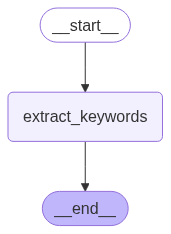

In [266]:
class KeyWordsModel(BaseModel):
    keywords: Annotated[list[str], "텍스트로 부터 추출한 키워드를 담는 리스트"]

llm = ChatOpenAI(
    model='gpt-4o',
    temperature=0
)
structured_llm = llm.with_structured_output(KeyWordsModel)

# Define State
class InputState(TypedDict):
    context: str

class OutputState(TypedDict):
    keywords: list[str]

class GraphState(InputState, OutputState):
    pass

# Define Nodes
def keyword_extraction_node(state: InputState):
    context = state['context']

    system_message_content = """
    당신은 전문적인 기업 트렌드 분석가 입니다.
    당신의 임무는 주어진 기업의 특정 기사에 대해 기업의 트렌드를 잘 나타낼 수 있는 주요 키워드를 선정하는 것입니다.
    다음의 지침을 준수하며 기업의 트렌드 분석이 가능하도록 키워드를 30개 추출하세요.

    <지침>
    1. '사업', '선두주자'와 같이 해당 기업에 대해 설명할 수 없는 너무 일반적인 키워드는 제외하세요.
    2. '~부문' 과 같이 특정 분야를 총괄하는 키워드는 제외하고, 기업에 대해 분석 가능한 직접적인 키워드를 선정하세요.
    </지침>
    """

    human_message_content = f"""
    다음의 기사에서 주요 키워드를 추출해주세요.

    기사:
    {context}
    """

    system_message = SystemMessage(content=system_message_content)
    human_message = HumanMessage(content=human_message_content)

    keyword_list = structured_llm.invoke([system_message, human_message])

    return {
        "keywords" : keyword_list.keywords
    }


# Define Graph Builder
workflow = StateGraph(
    GraphState,
    input=InputState,
    output=OutputState
)

# add nodes
workflow.add_node("extract_keywords", keyword_extraction_node)

# add edges
workflow.add_edge(START, "extract_keywords")
workflow.add_edge("extract_keywords", END)

# Compile Graph
role_app = workflow.compile()

role_app    


#### 4-2. Candidate-based Prompting

##### GPT-4o

In [11]:
def get_candidates(documents, stopwords=None, max_n:int=3):
    # define tagger
    tagger = Okt()
    candidates = []

    for document in tqdm(documents):
        tokens = tagger.nouns(document['context'])
        if stopwords: tokens = [token for token in tokens if token not in stopwords]
        candidate_phrases = set()

        for n in range(1, max_n+1):
            for i in range(len(tokens) - n + 1):
                gram = tokens[i:i+n]
                phrase = " ".join(gram)
                if len(phrase.strip()) == 0 or phrase.isdigit(): continue
                candidate_phrases.add(phrase)
        
        candidates.append(
            {
                'context' : document['context'],
                'candidates' : candidate_phrases,
                'terminology' : document['terminology']
            }
        )
    
    return candidates

stopwords = list(set(["종", "그", "및", "등", "각", "개", "를", "사", "위", "전", "용", "처", "통해", "기술", "부문", "경쟁력", "제품", "사업",
             "시장", "판매", "지속", "기업", "생산", "확대", "기업", "당사", "차별", "솔루션", "부품", "개발", "적용", "공정", "한편", "업체",
             "운영", "선두", "전장", "또한", "추진", "구성", "응용", "일반", "영위", "해외", "경영", "본사", "지역", "주요", "다음", "삼성",
             "협업", "서비스", "선단", "특화", "심화", "제품군", "설계", "대형", "세계", "소비자", "라인업", "혁신", "차세대", "공급", "글로벌", "고화질",
             "경쟁", "강화", "더블", "경험", "율", "의", "고하", "뿐", "로서", "탑재", "자체", "원가", "이", "저", "내", "전체", "것", "성공"]))

eval_dataset_with_candidates = get_candidates(eval_dataset[:100], stopwords=stopwords, max_n=2)

100%|██████████| 100/100 [00:03<00:00, 28.01it/s]


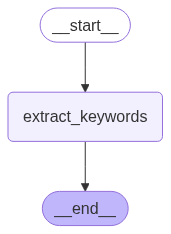

In [269]:
class KeyWordsModel(BaseModel):
    keywords: Annotated[list[str], "키워드 후보로 부터 선정한 주요 키워드를 담는 리스트"]

llm = ChatOpenAI(
    model='gpt-4o',
    temperature=0
)
structured_llm = llm.with_structured_output(KeyWordsModel)

# Define State
class InputState(TypedDict):
    context: str
    candidates: list[str]

class OutputState(TypedDict):
    keywords: list[str]

class GraphState(InputState, OutputState):
    pass

# Define Nodes
def keyword_extraction_node(state: InputState):
    context = state['context']
    candidates = state['candidates']

    system_message_content = """
    당신은 전문적인 기업 트렌드 분석가 입니다.
    당신의 임무는 주어진 기업의 특정 기사에 대한 키워드 후보에서 기업의 트렌드를 잘 나타낼 수 있는 주요 키워드를 선정하는 것입니다.
    다음의 지침을 준수하며 기업의 트렌드 분석이 가능하도록 키워드를 30개 선택하세요.

    <지침>
    1. '사업', '선두주자'와 같이 해당 기업에 대해 설명할 수 없는 너무 일반적인 키워드는 제외하세요.
    2. '~부문' 과 같이 특정 분야를 총괄하는 키워드는 제외하고, 기업에 대해 분석 가능한 직접적인 키워드를 선정하세요.
    </지침>
    """

    human_message_content = f"""
    다음의 키워드 후보에서 주어진 기사의 주요 키워드를 선정해주세요.

    기사:
    {context}

    키워드 후보:
    {candidates}
    """

    system_message = SystemMessage(content=system_message_content)
    human_message = HumanMessage(content=human_message_content)

    keyword_list = structured_llm.invoke([system_message, human_message])

    return {
        "keywords" : keyword_list.keywords
    }


# Define Graph Builder
workflow = StateGraph(
    GraphState,
    input=InputState,
    output=OutputState
)

# add nodes
workflow.add_node("extract_keywords", keyword_extraction_node)

# add edges
workflow.add_edge(START, "extract_keywords")
workflow.add_edge("extract_keywords", END)

# Compile Graph
candidate_app = workflow.compile()

candidate_app    


##### anthropic claude-sonnet-4-20250514

In [21]:
def get_candidates(documents, stopwords=None, max_n:int=3):
    # define tagger
    tagger = Okt()
    candidates = []

    for document in tqdm(documents):
        tokens = tagger.nouns(document['context'])
        if stopwords: tokens = [token for token in tokens if token not in stopwords]
        candidate_phrases = set()

        for n in range(1, max_n+1):
            for i in range(len(tokens) - n + 1):
                gram = tokens[i:i+n]
                phrase = " ".join(gram)
                if len(phrase.strip()) == 0 or phrase.isdigit(): continue
                candidate_phrases.add(phrase)
        
        candidates.append(
            {
                'context' : document['context'],
                'candidates' : candidate_phrases,
                'terminology' : document['terminology']
            }
        )
    
    return candidates

stopwords = list(set(["종", "그", "및", "등", "각", "개", "를", "사", "위", "전", "용", "처", "통해", "기술", "부문", "경쟁력", "제품", "사업",
             "시장", "판매", "지속", "기업", "생산", "확대", "기업", "당사", "차별", "솔루션", "부품", "개발", "적용", "공정", "한편", "업체",
             "운영", "선두", "전장", "또한", "추진", "구성", "응용", "일반", "영위", "해외", "경영", "본사", "지역", "주요", "다음", "삼성",
             "협업", "서비스", "선단", "특화", "심화", "제품군", "설계", "대형", "세계", "소비자", "라인업", "혁신", "차세대", "공급", "글로벌", "고화질",
             "경쟁", "강화", "더블", "경험", "율", "의", "고하", "뿐", "로서", "탑재", "자체", "원가", "이", "저", "내", "전체", "것", "성공"]))

eval_dataset_with_candidates = get_candidates(eval_dataset[:100], stopwords=stopwords, max_n=2)

100%|██████████| 100/100 [00:02<00:00, 37.22it/s]


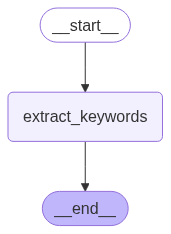

In [45]:
class KeyWordsModel(BaseModel):
    keywords: Annotated[list[str], "키워드 후보로 부터 선정한 주요 키워드를 담는 리스트"]

llm = ChatAnthropic(
    model="claude-sonnet-4-20250514",
    temperature=0
)
structured_llm = llm.with_structured_output(KeyWordsModel)

# Define State
class InputState(TypedDict):
    context: str
    candidates: list[str]

class OutputState(TypedDict):
    keywords: list[str]

class GraphState(InputState, OutputState):
    pass

# Define Nodes
def keyword_extraction_node(state: InputState):
    context = state['context']
    candidates = state['candidates']

    system_message_content = """
    당신은 전문적인 기업 트렌드 분석가 입니다.
    당신의 임무는 주어진 기업의 특정 기사에 대한 키워드 후보에서 기업의 트렌드를 잘 나타낼 수 있는 주요 키워드를 선정하는 것입니다.
    다음의 지침을 준수하며 기업의 트렌드 분석이 가능하도록 키워드를 30개 선택하세요.

    <지침>
    1. '사업', '선두주자'와 같이 해당 기업에 대해 설명할 수 없는 너무 일반적인 키워드는 제외하세요.
    2. '~부문' 과 같이 특정 분야를 총괄하는 키워드는 제외하고, 기업에 대해 분석 가능한 직접적인 키워드를 선정하세요.
    </지침>
    """

    human_message_content = f"""
    다음의 키워드 후보에서 주어진 기사의 주요 키워드를 선정해주세요.

    기사:
    {context}

    키워드 후보:
    {candidates}
    """

    system_message = SystemMessage(content=system_message_content)
    human_message = HumanMessage(content=human_message_content)

    keyword_list = structured_llm.invoke(input=[system_message, human_message])

    return {
        "keywords" : keyword_list.keywords
    }


# Define Graph Builder
workflow = StateGraph(
    GraphState,
    input=InputState,
    output=OutputState
)

# add nodes
workflow.add_node("extract_keywords", keyword_extraction_node)

# add edges
workflow.add_edge(START, "extract_keywords")
workflow.add_edge("extract_keywords", END)

# Compile Graph
candidate_app = workflow.compile()

candidate_app    


#### 4-3. Hybrid Prompting

In [11]:
def get_candidates(documents, stopwords=None, max_n:int=3):
    # define tagger
    tagger = Okt()
    candidates = []

    for document in tqdm(documents):
        tokens = tagger.nouns(document['context'])
        if stopwords: tokens = [token for token in tokens if token not in stopwords]
        candidate_phrases = set()

        for n in range(1, max_n+1):
            for i in range(len(tokens) - n + 1):
                gram = tokens[i:i+n]
                phrase = " ".join(gram)
                if len(phrase.strip()) == 0 or phrase.isdigit(): continue
                candidate_phrases.add(phrase)
        
        candidates.append(
            {
                'context' : document['context'],
                'candidates' : candidate_phrases,
                'terminology' : document['terminology']
            }
        )
    
    return candidates

stopwords = list(set(["종", "그", "및", "등", "각", "개", "를", "사", "위", "전", "용", "처", "통해", "기술", "부문", "경쟁력", "제품", "사업",
             "시장", "판매", "지속", "기업", "생산", "확대", "기업", "당사", "차별", "솔루션", "부품", "개발", "적용", "공정", "한편", "업체",
             "운영", "선두", "전장", "또한", "추진", "구성", "응용", "일반", "영위", "해외", "경영", "본사", "지역", "주요", "다음", "삼성",
             "협업", "서비스", "선단", "특화", "심화", "제품군", "설계", "대형", "세계", "소비자", "라인업", "혁신", "차세대", "공급", "글로벌", "고화질",
             "경쟁", "강화", "더블", "경험", "율", "의", "고하", "뿐", "로서", "탑재", "자체", "원가", "이", "저", "내", "전체", "것", "성공"]))

eval_dataset_with_candidates = get_candidates(eval_dataset[:100], stopwords=stopwords, max_n=2)

100%|██████████| 100/100 [00:03<00:00, 28.11it/s]


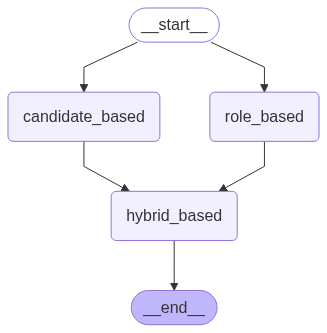

In [270]:
class KeyWordsModel(BaseModel):
    keywords: Annotated[list[str], "키워드 후보로 부터 선정한 주요 키워드를 담는 리스트"]

llm = ChatOpenAI(
    model='gpt-4o',
    temperature=0
)
structured_llm = llm.with_structured_output(KeyWordsModel)

# Define State
class InputState(TypedDict):
    context: str
    candidates: list[str]

class OutputState(TypedDict):
    keywords: list[str]

class GraphState(InputState, OutputState):
    candidate_based_keywords: list[str]
    role_based_keywords: list[str]
    pass

# Define Nodes
def candidate_based_node(state: InputState):
    context = state['context']
    candidates = state['candidates']

    system_message_content = """
    당신은 전문적인 기업 트렌드 분석가 입니다.
    당신의 임무는 주어진 기업의 특정 기사에 대한 키워드 후보에서 기업의 트렌드를 잘 나타낼 수 있는 주요 키워드를 선정하는 것입니다.
    다음의 지침을 준수하며 기업의 트렌드 분석이 가능하도록 키워드를 30개 추출하세요.

    <지침>
    1. '사업', '선두주자'와 같이 해당 기업에 대해 설명할 수 없는 너무 일반적인 키워드는 제외하세요.
    2. '~부문' 과 같이 특정 분야를 총괄하는 키워드는 제외하고, 기업에 대해 분석 가능한 직접적인 키워드를 선정하세요.
    </지침>
    """

    human_message_content = f"""
    다음의 키워드 후보에서 주어진 기사의 주요 키워드를 선정해주세요.

    기사:
    {context}

    키워드 후보:
    {candidates}
    """

    system_message = SystemMessage(content=system_message_content)
    human_message = HumanMessage(content=human_message_content)

    keyword_list = structured_llm.invoke([system_message, human_message])

    return {
        "candidate_based_keywords" : keyword_list.keywords
    }

def role_based_node(state: InputState):
    context = state['context']

    system_message_content = """
    당신은 전문적인 기업 트렌드 분석가 입니다.
    당신의 임무는 주어진 기업의 특정 기사에 대해 기업의 트렌드를 잘 나타낼 수 있는 주요 키워드를 선정하는 것입니다.
    다음의 지침을 준수하며 기업의 트렌드 분석이 가능하도록 키워드를 30개 추출하세요.

    <지침>
    1. '사업', '선두주자'와 같이 해당 기업에 대해 설명할 수 없는 너무 일반적인 키워드는 제외하세요.
    2. '~부문' 과 같이 특정 분야를 총괄하는 키워드는 제외하고, 기업에 대해 분석 가능한 직접적인 키워드를 선정하세요.
    </지침>
    """

    human_message_content = f"""
    다음의 기사에서 주요 키워드를 추출해주세요.

    기사:
    {context}
    """

    system_message = SystemMessage(content=system_message_content)
    human_message = HumanMessage(content=human_message_content)

    keyword_list = structured_llm.invoke([system_message, human_message])

    return {
        "role_based_keywords" : keyword_list.keywords
    }

def hybrid_based_node(state: GraphState):
    context = state['context']
    candidate_based_keywords = state['candidate_based_keywords']
    role_based_keywords = state['role_based_keywords']

    system_message_content = """
    당신은 전문적인 키워드 분석가입니다.
    당신의 임무는 주어진 기사에 대해 사전에 선정된 키워드 들을 검토하여 해당 기사를 더 잘 대표하는 키워드를 선정하는 것입니다.
    다음의 지침을 준수하며 기업 트렌드 분석이 가능하도록 키워드 30개를 선택하세요.

    <지침>
    1. '사업', '선두주자'와 같이 해당 기업에 대해 설명할 수 없는 너무 일반적인 키워드는 제외하세요.
    2. '~부문' 과 같이 특정 분야를 총괄하는 키워드는 제외하고, 기업에 대해 분석 가능한 직접적인 키워드를 선정하세요.
    3. 주어진 키워드내에서 선택하세요.
    </지침>
    """

    human_message_content = f"""
    주어진 키워드 후보에서 다음의 기사를 더 잘 대표하는 키워드를 선정하세요.

    기사:
    {context}

    키워드 후보:
    {set(candidate_based_keywords + role_based_keywords)}
    """

    system_message = SystemMessage(content=system_message_content)
    human_message = HumanMessage(content=human_message_content)

    keyword_list = structured_llm.invoke([system_message, human_message])

    return {
        "keywords" : keyword_list.keywords
    }


# Define Graph Builder
workflow = StateGraph(
    GraphState,
    input=InputState,
    output=OutputState
)

# add nodes
workflow.add_node("candidate_based", candidate_based_node)
workflow.add_node("role_based", role_based_node)
workflow.add_node("hybrid_based", hybrid_based_node)

# add edges
workflow.add_edge(START, "candidate_based")
workflow.add_edge(START, "role_based")
workflow.add_edge("candidate_based", "hybrid_based")
workflow.add_edge("role_based", "hybrid_based")
workflow.add_edge("hybrid_based", END)

# Compile Graph
hybrid_app = workflow.compile()

hybrid_app    

### 5. PromptRank

In [22]:
def get_candidates(documents, stopwords=None, max_n:int=3):
    # define tagger
    tagger = Okt()
    candidates = []

    for document in tqdm(documents):
        tokens = tagger.nouns(document['context'])
        if stopwords: tokens = [token for token in tokens if token not in stopwords]
        candidate_phrases = set()

        for n in range(1, max_n+1):
            for i in range(len(tokens) - n + 1):
                gram = tokens[i:i+n]
                phrase = " ".join(gram)
                if len(phrase.strip()) == 0 or phrase.isdigit(): continue
                candidate_phrases.add(phrase)
        
        candidates.append(
            {
                'context' : document['context'],
                'candidates' : candidate_phrases,
                'terminology' : document['terminology']
            }
        )
    
    return candidates

stopwords = list(set(["종", "그", "및", "등", "각", "개", "를", "사", "위", "전", "용", "처", "통해", "기술", "부문", "경쟁력", "제품", "사업",
             "시장", "판매", "지속", "기업", "생산", "확대", "기업", "당사", "차별", "솔루션", "부품", "개발", "적용", "공정", "한편", "업체",
             "운영", "선두", "전장", "또한", "추진", "구성", "응용", "일반", "영위", "해외", "경영", "본사", "지역", "주요", "다음", "삼성",
             "협업", "서비스", "선단", "특화", "심화", "제품군", "설계", "대형", "세계", "소비자", "라인업", "혁신", "차세대", "공급", "글로벌", "고화질",
             "경쟁", "강화", "더블", "경험", "율", "의", "고하", "뿐", "로서", "탑재", "자체", "원가", "이", "저", "내", "전체", "것", "성공"]))

eval_dataset_with_candidates = get_candidates(eval_dataset[:100], stopwords=stopwords, max_n=2)

100%|██████████| 100/100 [00:02<00:00, 43.31it/s]


In [23]:
from transformers import (
    PreTrainedTokenizerFast,
    BartForConditionalGeneration
)

MODEL = 'gogamza/kobart-base-v2'
tokenizer = PreTrainedTokenizerFast.from_pretrained(MODEL)
model = BartForConditionalGeneration.from_pretrained(MODEL)

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.


In [24]:
import torch

context = eval_dataset_with_candidates[0]['context']
encoder_prompt = f"뉴스: {context}"

enc_inputs = tokenizer(encoder_prompt, return_tensors='pt')
enc_input_ids = enc_inputs.input_ids
enc_attention_mask = enc_inputs.attention_mask

candidates = eval_dataset_with_candidates[0]['candidates']
candidate_scores = []
for phrase in tqdm(candidates):
    decoder_prompt = f"이 뉴스는 다음 주제에 대해 이야기 하고 있습니다. 주제:{phrase}"
    dec_inputs = tokenizer(decoder_prompt, return_tensors='pt')
    dec_input_ids = dec_inputs.input_ids

    with torch.no_grad():
        output = model(
            input_ids=enc_input_ids,
            attention_mask=enc_attention_mask,
            labels=dec_input_ids
        )
    
    loss = output.loss.item()
    score = -loss
    candidate_scores.append((phrase, score))

candidate_scores.sort(key=lambda x:x[1], reverse=True)

100%|██████████| 551/551 [01:34<00:00,  5.81it/s]


In [25]:
candidate_scores

[('센서 액추에이터', -8.670849800109863),
 ('액추에이터', -9.30936336517334),
 ('자동화', -9.489578247070312),
 ('액추에이터 연결', -9.506006240844727),
 ('액추에이터 부착', -9.564845085144043),
 ('액추에이터 장착', -9.711193084716797),
 ('무인', -10.080702781677246),
 ('발달 자동화', -10.101017951965332),
 ('원격 정보', -10.12484073638916),
 ('전자공학 발달', -10.241741180419922),
 ('최적화', -10.282442092895508),
 ('전송', -10.312067031860352),
 ('원격', -10.320932388305664),
 ('철도차량', -10.370210647583008),
 ('가장', -10.4131498336792),
 ('이더넷', -10.460270881652832),
 ('단점 데이지', -10.462307929992676),
 ('이더넷 먼저', -10.466142654418945),
 ('센서', -10.478841781616211),
 ('단점 따라서', -10.49381160736084),
 ('정보 전달', -10.501200675964355),
 ('론 전자공학', -10.501386642456055),
 ('이더넷 통합', -10.54490852355957),
 ('경유', -10.557591438293457),
 ('지연', -10.574026107788086),
 ('논문 철도차량', -10.583672523498535),
 ('하이브리드', -10.584729194641113),
 ('각각 차량', -10.586249351501465),
 ('전자공학', -10.589249610900879),
 ('통신 통신', -10.590189933776855),
 ('데이터 전송', -10.6055278778076

### 6. HybridMatch

In [196]:
import torch, torch.nn.functional as F

def attn_pool(tokens_emb: torch.tensor) -> torch.Tensor:
    """
    토큰 임베딩 nxd → 구문 벡터 1xd
    n == 1  ➜  그 벡터 그대로 반환
    n >= 2 ➜  dot-product self attention 후 가중합
    """
    n, d = tokens_emb.shape
    if n == 0:
        raise ValueError("빈 후보입니다.")
    # 1‑토큰 후보면 softmax 계산이 의미 없으니 그대로 리턴
    if n == 1:
        return tokens_emb.squeeze(0)

    q = tokens_emb.mean(dim=0, keepdim=True)           # [1, d]
    attn_logits = (tokens_emb @ q.T).squeeze(-1)       # [n]
    attn = F.softmax(attn_logits, dim=0)               # [n]
    pooled = (attn.unsqueeze(1) * tokens_emb).sum(dim=0)  # [d]
    return list(pooled)

In [256]:
def preprocess(documents, stopwords=None, n:int=2):
    tagger = Okt()
    embed_model = OpenAIEmbeddings()
    result = []

    # calc h_hat
    for document in tqdm(documents):
        nouns = tagger.nouns(document['context'])
        if stopwords: nouns = [noun for noun in nouns if noun not in stopwords]

        # get h_hat
        h_hat = embed_model.embed_documents(nouns)

        # get keyphrase representation
        word_level_representation = []
        phrase_level_representation = []
        for i in range(len(h_hat) - n + 1): 
            word_level_representation.append(h_hat[i:i+n])
            phrase_level_representation.append(attn_pool(torch.tensor(h_hat[i:i+n])))
        
        result.append(
            {
                'context' : document['context'],
                'terminology' : document['terminology'],
                'tokens' : nouns,
                'document_representation' : h_hat,
                'word_level_representation' : word_level_representation,
                'phrase_level_representation' : phrase_level_representation,
            }
        )
    
    return result

stopwords = list(set(["종", "그", "및", "등", "각", "개", "를", "사", "위", "전", "용", "처", "통해", "기술", "부문", "경쟁력", "제품", "사업",
             "시장", "판매", "지속", "기업", "생산", "확대", "기업", "당사", "차별", "솔루션", "부품", "개발", "적용", "공정", "한편", "업체",
             "운영", "선두", "전장", "또한", "추진", "구성", "응용", "일반", "영위", "해외", "경영", "본사", "지역", "주요", "다음", "삼성",
             "협업", "서비스", "선단", "특화", "심화", "제품군", "설계", "대형", "세계", "소비자", "라인업", "혁신", "차세대", "공급", "글로벌", "고화질",
             "경쟁", "강화", "더블", "경험", "율", "의", "고하", "뿐", "로서", "탑재", "자체", "원가", "이", "저", "내", "전체", "것", "성공"]))

preprocessed = preprocess(eval_dataset[:100], stopwords=stopwords)

100%|██████████| 100/100 [03:58<00:00,  2.38s/it]


In [257]:
def interaction_focused_module(doc_rep, word_lev_rep):
    s_pp_batch = word_lev_rep @ doc_rep.unsqueeze(0).transpose(1,2)

    max_pooled = torch.max(s_pp_batch, dim=2).values
    mean_pooled = torch.mean(s_pp_batch, dim=2)

    overall_max_pooled = torch.mean(max_pooled, dim=1, keepdim=True)
    overall_mean_pooled = torch.mean(mean_pooled, dim=1, keepdim=True)

    return torch.concat([overall_max_pooled, overall_mean_pooled], dim=1) 

def representation_focused_module(doc_rep, phrase_lev_rep):
    r_pw_batch = phrase_lev_rep @ doc_rep.T

    max_pooled = torch.max(r_pw_batch, dim=1, keepdim=True).values
    mean_pooled = torch.mean(r_pw_batch, dim=1, keepdim=True)

    return torch.concat([max_pooled, mean_pooled], dim=1)

def get_im_score(documents):
    result = []
    for document in tqdm(documents):
        doc_rep = document['document_representation']
        word_lev_rep = document['word_level_representation']
        im_score = interaction_focused_module(
            torch.tensor(doc_rep), 
            torch.tensor(word_lev_rep)
        )

        result.append({
            'context': document['context'],
            'terminology': document['terminology'],
            'tokens' : document['tokens'],
            'document_representation' : document['document_representation'],
            'word_level_representation' : document['word_level_representation'],
            'phrase_level_representation' : document['phrase_level_representation'],
            'im_score' : im_score
        })
    
    return result

def get_rm_score(documents):
    result = []
    for document in tqdm(documents):
        doc_rep = document['document_representation']
        phrase_lev_rep = document['phrase_level_representation']
        rm_score = representation_focused_module(
            torch.tensor(doc_rep),
            torch.tensor(phrase_lev_rep)
        )

        result.append({
            'context': document['context'],
            'terminology': document['terminology'],
            'tokens' : document['tokens'],
            'document_representation' : document['document_representation'],
            'word_level_representation' : document['word_level_representation'],
            'phrase_level_representation' : document['phrase_level_representation'],
            'im_score' : document['im_score'],
            'rm_score' : rm_score
        })
    
    return result

def get_matching_score(documents):
    result = []

    for document in tqdm(documents):
        im_score = document['im_score']
        rm_score = document['rm_score']

        r_nm = torch.mean(torch.mul(im_score, rm_score), dim=1, keepdim=True)

        result.append({
            'context': document['context'],
            'terminology': document['terminology'],
            'tokens' : document['tokens'],
            'document_representation' : document['document_representation'],
            'word_level_representation' : document['word_level_representation'],
            'phrase_level_representation' : document['phrase_level_representation'],
            'im_score' : document['im_score'],
            'rm_score' : document['rm_score'],
            'matching_score' : r_nm
        })
    
    return result

        

im_scored = get_im_score(preprocessed)
rm_scored = get_rm_score(im_scored)
final_scored = get_matching_score(rm_scored)

100%|██████████| 100/100 [00:00<00:00, 56466.13it/s]


In [263]:
def get_top_n(documents, top_n):
    result = []

    for document in tqdm(documents):
        indices = sorted(range(len(document['phrase_level_representation'])), key=lambda i: document['matching_score'][i])
        sorted_tokens = [" ".join(document['tokens'][i:i+2]) for i in indices]

        result.append({
            'context': document['context'],
            'terminology': document['terminology'],
            'tokens' : document['tokens'],
            'document_representation' : document['document_representation'],
            'word_level_representation' : document['word_level_representation'],
            'phrase_level_representation' : document['phrase_level_representation'],
            'im_score' : document['im_score'],
            'rm_score' : document['rm_score'],
            'matching_score' : document['matching_score'],
            'keywords' : sorted_tokens[:top_n]
        })
    
    return result

keywords = get_top_n(final_scored, 30)

100%|██████████| 100/100 [00:00<00:00, 971.19it/s]


## Construct Evaluate Process

### Critic Function

In [17]:
def calculate_keyword_metrics(ground_truth, predicted):
    gt_set = set(ground_truth)
    pred_set = set(predicted)
    
    # True Positive: 예측한 키워드 중 정답에 포함된 것
    tp = len(gt_set.intersection(pred_set))
    # False Positive: 예측한 키워드 중 정답에 포함되지 않은 것
    fp = len(pred_set - gt_set)
    # False Negative: 정답 키워드 중 예측하지 못한 것
    fn = len(gt_set - pred_set)

    # Precision
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    # Recall
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    # F1 Score
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'tp': tp,
        'fp': fp,
        'fn': fn,
        'ground_truth_count': len(gt_set),
        'predicted_count': len(pred_set)
    }

### TextRank

In [15]:
stopwords = list(set(["종", "그", "및", "등", "각", "개", "를", "사", "위", "전", "용", "처", "통해", "기술", "부문", "경쟁력", "제품", "사업",
             "시장", "판매", "지속", "기업", "생산", "확대", "기업", "당사", "차별", "솔루션", "부품", "개발", "적용", "공정", "한편", "업체",
             "운영", "선두", "전장", "또한", "추진", "구성", "응용", "일반", "영위", "해외", "경영", "본사", "지역", "주요", "다음", "삼성",
             "협업", "서비스", "선단", "특화", "심화", "제품군", "설계", "대형", "세계", "소비자", "라인업", "혁신", "차세대", "공급", "글로벌", "고화질",
             "경쟁", "강화", "더블", "경험", "율", "의", "고하", "뿐", "로서", "탑재", "자체", "원가", "간", "수", "경우", "내", "따라서", "대한"]))

eval_results = []
for gt in tqdm(eval_dataset[:100], desc="TextRank Evaluating... : "):
    text = gt['context']
    gt_keywords = gt['terminology']

    textrank_extractor = TextRankKeywordExtractor(text, stopwords=stopwords)
    pred_keywords = textrank_extractor.extract(
        window=3,
        max_iter=30,
        top_n=30
    )

    eval_results.append(calculate_keyword_metrics(
        ground_truth=gt_keywords,
        predicted=pred_keywords
    ))

TextRank Evaluating... : 100%|██████████| 100/100 [00:02<00:00, 33.39it/s]


In [16]:
total_precision = 0
total_recall = 0
total_f1 = 0
total_gt_cnt = 0
total_pred_cnt = 0
eval_amount = len(eval_results)

for eval in eval_results:
    total_precision += eval['precision']
    total_recall += eval['recall']
    total_f1 += eval['f1_score']
    total_gt_cnt += eval['ground_truth_count']
    total_pred_cnt += eval['predicted_count']

print(
    f" Avg Precision : {total_precision / eval_amount}\n",
    f"Avg recall : {total_recall / eval_amount}\n",
    f"Avg f1 score : {total_f1 / eval_amount}\n",
    f"Avg ground truth count : {total_gt_cnt / eval_amount}\n",
    f"Avg predicted count : {total_pred_cnt / eval_amount}\n"
)

 Avg Precision : 0.10423194192377493
 Avg recall : 0.12393775441033852
 Avg f1 score : 0.10323048807776919
 Avg ground truth count : 32.19
 Avg predicted count : 29.76



### Embedding Based

In [17]:
stopwords = list(set(["종", "그", "및", "등", "각", "개", "를", "사", "위", "전", "용", "처", "통해", "기술", "부문", "경쟁력", "제품", "사업",
             "시장", "판매", "지속", "기업", "생산", "확대", "기업", "당사", "차별", "솔루션", "부품", "개발", "적용", "공정", "한편", "업체",
             "운영", "선두", "전장", "또한", "추진", "구성", "응용", "일반", "영위", "해외", "경영", "본사", "지역", "주요", "다음", "삼성",
             "협업", "서비스", "선단", "특화", "심화", "제품군", "설계", "대형", "세계", "소비자", "라인업", "혁신", "차세대", "공급", "글로벌", "고화질",
             "경쟁", "강화", "더블", "경험", "율", "의", "고하", "뿐", "로서", "탑재", "자체", "원가", "간", "수", "경우", "내", "따라서", "대한"]))

eval_results = []
for gt in tqdm(eval_dataset[:100], desc="Embedding Based Evaluating... : "):
    text = gt['context']
    gt_keywords = gt['terminology']

    embeddingbased_extractor = OpenAIEmbeddingBasedExtractor(text, stopwords=stopwords)
    pred_keywords = embeddingbased_extractor.extract(
        top_n=30
    )

    if len(pred_keywords) == 0:
        eval_results.append(calculate_keyword_metrics(
            ground_truth=gt_keywords,
            predicted=pred_keywords
        ))
    else:
        eval_results.append(calculate_keyword_metrics(
            ground_truth=gt_keywords,
            predicted=pred_keywords[0]
        ))    

Embedding Based Evaluating... : 100%|██████████| 100/100 [03:39<00:00,  2.20s/it]


In [19]:
total_precision = 0
total_recall = 0
total_f1 = 0
total_gt_cnt = 0
total_pred_cnt = 0
eval_amount = len(eval_results)

for eval in eval_results:
    total_precision += eval['precision']
    total_recall += eval['recall']
    total_f1 += eval['f1_score']
    total_gt_cnt += eval['ground_truth_count']
    total_pred_cnt += eval['predicted_count']

print(
    f" Avg Precision : {total_precision / eval_amount}\n",
    f"Avg recall : {total_recall / eval_amount}\n",
    f"Avg f1 score : {total_f1 / eval_amount}\n",
    f"Avg ground truth count : {total_gt_cnt / eval_amount}\n",
    f"Avg predicted count : {total_pred_cnt / eval_amount}\n"
)

 Avg Precision : 0.14589860859044146
 Avg recall : 0.1681523442769958
 Avg f1 score : 0.14262896542578957
 Avg ground truth count : 32.19
 Avg predicted count : 29.76



### KeyBERT

In [20]:
stopwords = list(set(["종", "그", "및", "등", "각", "개", "를", "사", "위", "전", "용", "처", "통해", "기술", "부문", "경쟁력", "제품", "사업",
             "시장", "판매", "지속", "기업", "생산", "확대", "기업", "당사", "차별", "솔루션", "부품", "개발", "적용", "공정", "한편", "업체",
             "운영", "선두", "전장", "또한", "추진", "구성", "응용", "일반", "영위", "해외", "경영", "본사", "지역", "주요", "다음", "삼성",
             "협업", "서비스", "선단", "특화", "심화", "제품군", "설계", "대형", "세계", "소비자", "라인업", "혁신", "차세대", "공급", "글로벌", "고화질",
             "경쟁", "강화", "더블", "경험", "율", "의", "고하", "뿐", "로서", "탑재", "자체", "원가", "간", "수", "경우", "내", "따라서", "대한"]))

eval_results = []
for gt in tqdm(eval_dataset[:100], desc="KeyBERT Evaluating... : "):
    text = gt['context']
    gt_keywords = gt['terminology']

    model = BertModel.from_pretrained('skt/kobert-base-v1')
    keybert_extractor = KeyBERTExtractor(text, model=model, stopwords=stopwords)
    pred_keywords = keybert_extractor.extract(
        top_n=30
    )

    if len(pred_keywords) == 0:
        eval_results.append(calculate_keyword_metrics(
            ground_truth=gt_keywords,
            predicted=pred_keywords
        ))
    else:
        pred_keywords = [word for word, score in pred_keywords]
        eval_results.append(calculate_keyword_metrics(
            ground_truth=gt_keywords,
            predicted=pred_keywords
        ))

KeyBERT Evaluating... :  16%|█▌        | 16/100 [01:06<05:39,  4.04s/it]HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2/resolve/main/1_Pooling/config.json
Retrying in 1s [Retry 1/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2/resolve/main/1_Pooling/config.json
Retrying in 2s [Retry 2/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2/resolve/main/1_Pooling/config.json
Retrying in 4s [Retry 3/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2/resolve/main/1_Pooling/config.json
Retrying in 8s [Retry 4/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2/resolve/main/1_Pooling/config.json
Retryi

In [21]:
total_precision = 0
total_recall = 0
total_f1 = 0
total_gt_cnt = 0
total_pred_cnt = 0
eval_amount = len(eval_results)

for eval in eval_results:
    total_precision += eval['precision']
    total_recall += eval['recall']
    total_f1 += eval['f1_score']
    total_gt_cnt += eval['ground_truth_count']
    total_pred_cnt += eval['predicted_count']

print(
    f" Avg Precision : {total_precision / eval_amount}\n",
    f"Avg recall : {total_recall / eval_amount}\n",
    f"Avg f1 score : {total_f1 / eval_amount}\n",
    f"Avg ground truth count : {total_gt_cnt / eval_amount}\n",
    f"Avg predicted count : {total_pred_cnt / eval_amount}\n"
)

 Avg Precision : 0.13720330394243427
 Avg recall : 0.1555867222443692
 Avg f1 score : 0.13414991838596302
 Avg ground truth count : 32.19
 Avg predicted count : 29.29



In [27]:
stopwords = list(set(["종", "그", "및", "등", "각", "개", "를", "사", "위", "전", "용", "처", "통해", "기술", "부문", "경쟁력", "제품", "사업",
             "시장", "판매", "지속", "기업", "생산", "확대", "기업", "당사", "차별", "솔루션", "부품", "개발", "적용", "공정", "한편", "업체",
             "운영", "선두", "전장", "또한", "추진", "구성", "응용", "일반", "영위", "해외", "경영", "본사", "지역", "주요", "다음", "삼성",
             "협업", "서비스", "선단", "특화", "심화", "제품군", "설계", "대형", "세계", "소비자", "라인업", "혁신", "차세대", "공급", "글로벌", "고화질",
             "경쟁", "강화", "더블", "경험", "율", "의", "고하", "뿐", "로서", "탑재", "자체", "원가", "간", "수", "경우", "내", "따라서", "대한"]))

eval_results = []
for gt in tqdm(eval_dataset[:100], desc="KeyBERT Evaluating... : "):
    text = gt['context']
    gt_keywords = gt['terminology']

    model = BertModel.from_pretrained('skt/kobert-base-v1')
    keybert_extractor = KeyBERTExtractor(text, model=model, stopwords=stopwords)
    pred_keywords = keybert_extractor.extract(
        top_n=30,
        use_mmr=True,
        use_msum=True
    )

    if len(pred_keywords) == 0:
        eval_results.append(calculate_keyword_metrics(
            ground_truth=gt_keywords,
            predicted=pred_keywords
        ))
    else:
        pred_keywords = [word for word, score in pred_keywords]
        eval_results.append(calculate_keyword_metrics(
            ground_truth=gt_keywords,
            predicted=pred_keywords
        ))

KeyBERT Evaluating... :  16%|█▌        | 16/100 [01:06<05:52,  4.20s/it]HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2/resolve/main/config.json
Retrying in 1s [Retry 1/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2/resolve/main/config.json
Retrying in 2s [Retry 2/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2/resolve/main/config.json
Retrying in 4s [Retry 3/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2/resolve/main/config.json
Retrying in 8s [Retry 4/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2/resolve/main/config.json
Retrying in 8s [Retry 5/5].
HTTP Error 429 thrown while 

In [28]:
total_precision = 0
total_recall = 0
total_f1 = 0
total_gt_cnt = 0
total_pred_cnt = 0
eval_amount = len(eval_results)

for eval in eval_results:
    total_precision += eval['precision']
    total_recall += eval['recall']
    total_f1 += eval['f1_score']
    total_gt_cnt += eval['ground_truth_count']
    total_pred_cnt += eval['predicted_count']

print(
    f" Avg Precision : {total_precision / eval_amount}\n",
    f"Avg recall : {total_recall / eval_amount}\n",
    f"Avg f1 score : {total_f1 / eval_amount}\n",
    f"Avg ground truth count : {total_gt_cnt / eval_amount}\n",
    f"Avg predicted count : {total_pred_cnt / eval_amount}\n"
)

 Avg Precision : 0.12286997060910097
 Avg recall : 0.1424349653012377
 Avg f1 score : 0.12057443446260702
 Avg ground truth count : 32.19
 Avg predicted count : 29.29



### LLM Based

#### Role Prompting

In [272]:
eval_results = []
for gt in tqdm(eval_dataset[:100], desc="LLM Based Evaluating... : "):
    text = gt['context']
    gt_keywords = gt['terminology']

    pred_keywords = role_app.invoke({"context" : text})

    eval_results.append(calculate_keyword_metrics(
        ground_truth=gt_keywords,
        predicted=pred_keywords['keywords']
    ))

LLM Based Evaluating... : 100%|██████████| 100/100 [06:10<00:00,  3.70s/it]


In [273]:
total_precision = 0
total_recall = 0
total_f1 = 0
total_gt_cnt = 0
total_pred_cnt = 0
eval_amount = len(eval_results)

for eval in eval_results:
    total_precision += eval['precision']
    total_recall += eval['recall']
    total_f1 += eval['f1_score']
    total_gt_cnt += eval['ground_truth_count']
    total_pred_cnt += eval['predicted_count']

print(
    f" Avg Precision : {total_precision / eval_amount:.4f}\n",
    f"Avg recall : {total_recall / eval_amount:.4f}\n",
    f"Avg f1 score : {total_f1 / eval_amount:.4f}\n",
    f"Avg ground truth count : {total_gt_cnt / eval_amount:.4f}\n",
    f"Avg predicted count : {total_pred_cnt / eval_amount:.4f}\n"
)

 Avg Precision : 0.3363
 Avg recall : 0.3604
 Avg f1 score : 0.3193
 Avg ground truth count : 32.1900
 Avg predicted count : 29.9100



#### Candidate Based

##### gpt-4o

In [ ]:
eval_results = []
for gt in tqdm(eval_dataset_with_candidates[:100], desc="LLM Based Evaluating... : "):
    text = gt['context']
    gt_keywords = gt['terminology']
    candidates = gt['candidates']

    pred_keywords = candidate_app.invoke({"context" : text, 'candidates' : candidates})

    eval_results.append(calculate_keyword_metrics(
        ground_truth=gt_keywords,
        predicted=pred_keywords['keywords']
    ))

LLM Based Evaluating... : 100%|██████████| 100/100 [08:46<00:00,  5.26s/it]


In [276]:
total_precision = 0
total_recall = 0
total_f1 = 0
total_gt_cnt = 0
total_pred_cnt = 0
eval_amount = len(eval_results)

for eval in eval_results:
    total_precision += eval['precision']
    total_recall += eval['recall']
    total_f1 += eval['f1_score']
    total_gt_cnt += eval['ground_truth_count']
    total_pred_cnt += eval['predicted_count']

print(
    f" Avg Precision : {total_precision / eval_amount:.4f}\n",
    f"Avg recall : {total_recall / eval_amount:.4f}\n",
    f"Avg f1 score : {total_f1 / eval_amount:.4f}\n",
    f"Avg ground truth count : {total_gt_cnt / eval_amount:.4f}\n",
    f"Avg predicted count : {total_pred_cnt / eval_amount:.4f}\n"
)

 Avg Precision : 0.3526
 Avg recall : 0.3712
 Avg f1 score : 0.3340
 Avg ground truth count : 32.1900
 Avg predicted count : 29.7800



##### anthropic claude-sonnet-4-20250514

In [46]:
eval_results = []
for gt in tqdm(eval_dataset_with_candidates[:100], desc="LLM Based Evaluating... : "):
    text = gt['context']
    gt_keywords = gt['terminology']
    candidates = gt['candidates']

    pred_keywords = candidate_app.invoke(input={"context" : text, 'candidates' : candidates})

    eval_results.append(calculate_keyword_metrics(
        ground_truth=gt_keywords,
        predicted=pred_keywords['keywords']
    ))

LLM Based Evaluating... : 100%|██████████| 100/100 [16:52<00:00, 10.12s/it]


In [47]:
total_precision = 0
total_recall = 0
total_f1 = 0
total_gt_cnt = 0
total_pred_cnt = 0
eval_amount = len(eval_results)

for eval in eval_results:
    total_precision += eval['precision']
    total_recall += eval['recall']
    total_f1 += eval['f1_score']
    total_gt_cnt += eval['ground_truth_count']
    total_pred_cnt += eval['predicted_count']

print(
    f" Avg Precision : {total_precision / eval_amount:.4f}\n",
    f"Avg recall : {total_recall / eval_amount:.4f}\n",
    f"Avg f1 score : {total_f1 / eval_amount:.4f}\n",
    f"Avg ground truth count : {total_gt_cnt / eval_amount:.4f}\n",
    f"Avg predicted count : {total_pred_cnt / eval_amount:.4f}\n"
)

 Avg Precision : 0.3563
 Avg recall : 0.3876
 Avg f1 score : 0.3404
 Avg ground truth count : 32.1900
 Avg predicted count : 30.0000



#### Hybrid prompting

In [277]:
eval_results = []
for gt in tqdm(eval_dataset_with_candidates[:100], desc="LLM Based Evaluating... : "):
    text = gt['context']
    gt_keywords = gt['terminology']
    candidates = gt['candidates']

    pred_keywords = hybrid_app.invoke({"context" : text, 'candidates' : candidates})

    eval_results.append(calculate_keyword_metrics(
        ground_truth=gt_keywords,
        predicted=pred_keywords['keywords']
    ))

LLM Based Evaluating... : 100%|██████████| 100/100 [14:21<00:00,  8.62s/it]


In [278]:
total_precision = 0
total_recall = 0
total_f1 = 0
total_gt_cnt = 0
total_pred_cnt = 0
eval_amount = len(eval_results)

for eval in eval_results:
    total_precision += eval['precision']
    total_recall += eval['recall']
    total_f1 += eval['f1_score']
    total_gt_cnt += eval['ground_truth_count']
    total_pred_cnt += eval['predicted_count']

print(
    f" Avg Precision : {total_precision / eval_amount:.4f}\n",
    f"Avg recall : {total_recall / eval_amount:.4f}\n",
    f"Avg f1 score : {total_f1 / eval_amount:.4f}\n",
    f"Avg ground truth count : {total_gt_cnt / eval_amount:.4f}\n",
    f"Avg predicted count : {total_pred_cnt / eval_amount:.4f}\n"
)

 Avg Precision : 0.3193
 Avg recall : 0.3358
 Avg f1 score : 0.3019
 Avg ground truth count : 32.1900
 Avg predicted count : 29.6300



### HybridMatching

In [264]:
eval_results = []
for gt in tqdm(keywords, desc="HybridMatching Evaluating... : "):
    text = gt['context']
    gt_keywords = gt['terminology']
    pred_keywords = gt['keywords']

    eval_results.append(calculate_keyword_metrics(
        ground_truth=gt_keywords,
        predicted=pred_keywords
    ))

HybridMatching Evaluating... : 100%|██████████| 100/100 [00:00<00:00, 76038.87it/s]


In [265]:
total_precision = 0
total_recall = 0
total_f1 = 0
total_gt_cnt = 0
total_pred_cnt = 0
eval_amount = len(eval_results)

for eval in eval_results:
    total_precision += eval['precision']
    total_recall += eval['recall']
    total_f1 += eval['f1_score']
    total_gt_cnt += eval['ground_truth_count']
    total_pred_cnt += eval['predicted_count']

print(
    f" Avg Precision : {total_precision / eval_amount:.4f}\n",
    f"Avg recall : {total_recall / eval_amount:.4f}\n",
    f"Avg f1 score : {total_f1 / eval_amount:.4f}\n",
    f"Avg ground truth count : {total_gt_cnt / eval_amount:.4f}\n",
    f"Avg predicted count : {total_pred_cnt / eval_amount:.4f}\n"
)

 Avg Precision : 0.0258
 Avg recall : 0.0333
 Avg f1 score : 0.0266
 Avg ground truth count : 32.1900
 Avg predicted count : 26.2000

